### Сессия 1

### 1.1 Парсинг данных

#### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

#### Загрузка данных

In [4]:
covid = pd.read_csv("owid-covid-data.csv", delimiter=',')

In [6]:
# опция для снятия ограничения на количество столбцов
pd.set_option('display.max_columns', None)
covid.head(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.122,0.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
5,AFG,Asia,Afghanistan,2020-02-29,5.0,0.0,0.714,NaN,NaN,NaN,0.122,0.000,0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
6,AFG,Asia,Afghanistan,2020-03-01,5.0,0.0,0.714,NaN,NaN,NaN,0.122,0.000,0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
7,AFG,Asia,Afghanistan,2020-03-02,5.0,0.0,0.000,NaN,NaN,NaN,0.122,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.78,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [7]:
# Размерность набора данных
covid.shape

(257737, 67)

In [8]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257737 entries, 0 to 257736
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    257737 non-null  object 
 1   continent                                   243270 non-null  object 
 2   location                                    257737 non-null  object 
 3   date                                        257737 non-null  object 
 4   total_cases                                 243255 non-null  float64
 5   new_cases                                   242975 non-null  float64
 6   new_cases_smoothed                          241771 non-null  float64
 7   total_deaths                                223598 non-null  float64
 8   new_deaths                                  223496 non-null  float64
 9   new_deaths_smoothed                         222310 non-null  float64
 

#### Информация о наличии пустых значений

In [9]:
# опция для снятия ограничения на количество строк
pd.set_option('display.max_rows', None)

In [10]:
covid.isnull().sum()

iso_code                                           0
continent                                      14467
location                                           0
date                                               0
total_cases                                    14482
new_cases                                      14762
new_cases_smoothed                             15966
total_deaths                                   34139
new_deaths                                     34241
new_deaths_smoothed                            35427
total_cases_per_million                        15587
new_cases_per_million                          15867
new_cases_smoothed_per_million                 17066
total_deaths_per_million                       35231
new_deaths_per_million                         35333
new_deaths_smoothed_per_million                36514
reproduction_rate                              72920
icu_patients                                  223309
icu_patients_per_million                      

### 1.2 Предобработка данных и выделение значимых атрибутов

Отбор признаков (feature selection) – это оценка важности того или иного признака с помощью алгоритмов машинного обучения и отсечение ненужных.

Присутствие в данных неинформативных признаков приводит к снижению точности многих моделей, особенно линейных, таких как линейная и логистическая регрессия.

Количество пропущенных значений (удаляются признаки у которых процент пропущенных значений больше порогового, зададим 0,6).

In [11]:
ops = {}
# Вычислим долю пропущенных значений в каждом столбце
missing_series = covid.isnull().sum() / covid.shape[0]
missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

# Сортируем по доле пропущенных значений по убыванию
missing_stats = missing_stats.sort_values('missing_fraction', ascending = False)

# Найдите столбцы с недостающим процентом выше порогового значения
record_missing = pd.DataFrame(missing_series[missing_series >0.3]).reset_index().rename(columns = {'index': 'feature', 0: 'missing_fraction'})
to_drop = list(record_missing['feature'])
ops['missing'] = to_drop

In [12]:
missing_stats.tail(30)

,missing_fraction
female_smokers,0.390545
hospital_beds_per_thousand,0.283518
reproduction_rate,0.282924
stringency_index,0.281461
human_development_index,0.214525
aged_65_older,0.202664
aged_70_older,0.198384
cardiovasc_death_rate,0.196565
gdp_per_capita,0.195090
median_age,0.194171


In [13]:
ops['missing']

['icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'people_fully_vaccinated_per_hundred',
 'total_boosters_per_hundred',
 'new_vaccinations_smoothed_per_million',
 'new_people_vaccinated_smoothed',
 'new_people_vaccinated_smoothed_per_hundred',
 'extreme_poverty',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'excess_mortality_cumulative_absolute',
 'excess_mortality_cumulative',
 'excess_mortal

In [14]:
covid2 = covid.drop(ops['missing'], axis=1)

In [15]:
covid2.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.122,0.122,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0


In [16]:
covid2.shape

(257737, 29)

In [134]:
covid2.isnull().sum()

iso_code                               0
continent                          14623
location                               0
date                                   0
total_cases                        14540
new_cases                          14863
new_cases_smoothed                 16067
total_deaths                       34245
new_deaths                         34347
new_deaths_smoothed                35533
total_cases_per_million            15657
new_cases_per_million              15980
new_cases_smoothed_per_million     17179
total_deaths_per_million           35349
new_deaths_per_million             35451
new_deaths_smoothed_per_million    36632
reproduction_rate                  75750
stringency_index                   75373
population_density                 33429
median_age                         50583
aged_65_older                      52796
aged_70_older                      51681
gdp_per_capita                     50796
cardiovasc_death_rate              51212
diabetes_prevale

In [17]:
# Колонки с пропусками
hcols_with_na = [c for c in covid2.columns if covid2[c].isnull().sum() > 0]
hcols_with_na

['continent',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'stringency_index',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'hospital_beds_per_thousand',
 'life_expectancy',
 'human_development_index',
 'population']

#### Заполнение пропущенных значений

Обработка пропусков в числовых данных

In [20]:
covid2_drop = covid2.copy(deep=True)

In [21]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in covid2_drop.columns:
    # Количество пустых значений 
    temp_null_count = covid2_drop[covid2_drop[col].isnull()].shape[0]
    dt = str(covid2_drop[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / covid2_drop.shape[0]) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))
        med = covid2_drop[col].median()
        covid2_drop[col] = covid2_drop[col].fillna(med)

Колонка total_cases. Тип данных float64. Количество пустых значений 14482, 5.62%.
Колонка new_cases. Тип данных float64. Количество пустых значений 14762, 5.73%.
Колонка new_cases_smoothed. Тип данных float64. Количество пустых значений 15966, 6.19%.
Колонка total_deaths. Тип данных float64. Количество пустых значений 34139, 13.25%.
Колонка new_deaths. Тип данных float64. Количество пустых значений 34241, 13.29%.
Колонка new_deaths_smoothed. Тип данных float64. Количество пустых значений 35427, 13.75%.
Колонка total_cases_per_million. Тип данных float64. Количество пустых значений 15587, 6.05%.
Колонка new_cases_per_million. Тип данных float64. Количество пустых значений 15867, 6.16%.
Колонка new_cases_smoothed_per_million. Тип данных float64. Количество пустых значений 17066, 6.62%.
Колонка total_deaths_per_million. Тип данных float64. Количество пустых значений 35231, 13.67%.
Колонка new_deaths_per_million. Тип данных float64. Количество пустых значений 35333, 13.71%.
Колонка new_dea

In [22]:
covid2.isnull().sum()

iso_code                               0
continent                          14467
location                               0
date                                   0
total_cases                        14482
new_cases                          14762
new_cases_smoothed                 15966
total_deaths                       34139
new_deaths                         34241
new_deaths_smoothed                35427
total_cases_per_million            15587
new_cases_per_million              15867
new_cases_smoothed_per_million     17066
total_deaths_per_million           35231
new_deaths_per_million             35333
new_deaths_smoothed_per_million    36514
reproduction_rate                  72920
stringency_index                   72543
population_density                 33083
median_age                         50045
aged_65_older                      52234
aged_70_older                      51131
gdp_per_capita                     50282
cardiovasc_death_rate              50662
diabetes_prevale

In [23]:
covid2_drop.isnull().sum()

iso_code                               0
continent                          14467
location                               0
date                                   0
total_cases                            0
new_cases                              0
new_cases_smoothed                     0
total_deaths                           0
new_deaths                             0
new_deaths_smoothed                    0
total_cases_per_million                0
new_cases_per_million                  0
new_cases_smoothed_per_million         0
total_deaths_per_million               0
new_deaths_per_million                 0
new_deaths_smoothed_per_million        0
reproduction_rate                      0
stringency_index                       0
population_density                     0
median_age                             0
aged_65_older                          0
aged_70_older                          0
gdp_per_capita                         0
cardiovasc_death_rate                  0
diabetes_prevale

Обработка пропусков в категориальных признаках

In [24]:
covid2_drop[covid2_drop["continent"].isnull()]["location"].value_counts()

World                  1121
Lower middle income    1121
North America          1121
Asia                   1121
Upper middle income    1121
High income            1121
European Union         1120
Europe                 1120
Oceania                1118
International          1105
Africa                 1099
South America          1090
Low income             1089
Name: location, dtype: int64

In [25]:
covid2_drop[covid2_drop["continent"].isnull()].sample(10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population
2050,OWID_AFR,NaN,Africa,2022-10-02,12358031.0,213.0,1079.429,256764.0,0.0,5.429,8661.747,0.149,0.757,179.966,0.000,0.004,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,1.426737e+09
168186,OWID_NAM,NaN,North America,2022-02-09,90785240.0,240777.0,278851.429,1328789.0,4312.0,3215.000,151227.157,401.079,464.502,2213.454,7.183,5.355,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,6.003237e+08
253628,OWID_WRL,NaN,World,2020-07-22,15231213.0,275358.0,236599.286,672808.0,7419.0,5900.571,1909.845,34.527,29.667,84.364,0.930,0.740,1.10,44.31,58.045,30.9,8.696,5.355,15469.207,233.070,8.51,2.705,72.58,0.737,7.975105e+09
99448,OWID_HIC,NaN,High income,2020-05-13,3053551.0,38836.0,41621.286,263587.0,3280.0,3163.571,2441.836,31.056,33.283,210.783,2.623,2.530,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,1.250515e+09
1917,OWID_AFR,NaN,Africa,2022-05-22,11841251.0,7948.0,7303.857,253730.0,11.0,41.000,8299.535,5.571,5.119,177.839,0.008,0.029,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,1.426737e+09
75341,OWID_EUN,NaN,European Union,2020-09-27,2784877.0,26819.0,40726.000,146712.0,154.0,331.429,6186.597,59.578,90.473,325.920,0.342,0.736,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,4.501468e+08
74453,OWID_EUR,NaN,Europe,2021-05-17,46730247.0,56677.0,82544.714,1081364.0,1438.0,2000.000,62741.350,76.096,110.827,1451.870,1.931,2.685,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,7.448078e+08
244745,OWID_UMC,NaN,Upper middle income,2021-07-30,60639112.0,224016.0,207493.571,1708279.0,3913.0,4229.429,24006.731,88.687,82.146,676.299,1.549,1.674,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,2.525921e+09
134008,OWID_LIC,NaN,Low income,2022-07-06,2192152.0,838.0,881.857,47308.0,5.0,4.714,2971.987,1.136,1.196,64.137,0.007,0.006,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,7.376049e+08
175095,OWID_OCE,NaN,Oceania,2022-10-02,12407777.0,11073.0,8314.143,20052.0,8.0,51.857,275490.476,245.854,184.599,445.216,0.178,1.151,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.500,75.05,0.742,4.503886e+07


In [32]:
covid2_drop["continent"] = covid2_drop["continent"].fillna(covid2_drop["location"])

In [34]:
covid2_drop[covid2_drop["continent"]=="Asia"].sample(20)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population
251156,VNM,Asia,Vietnam,2022-01-25,2171527.0,15743.0,15628.429,37010.0,126.0,148.286,22116.270,160.337,159.170,376.9340,1.283,1.510,0.98,63.89,308.127,32.6,7.150,4.718,6171.884,245.465,6.00,2.60,75.40,0.704,9.818686e+07
169402,PRK,Asia,North Korea,2022-09-06,1.0,0.0,0.000,6.0,0.0,0.000,0.038,0.000,0.000,0.2300,0.000,0.000,0.95,44.31,211.701,35.3,9.491,6.139,12951.839,321.681,4.00,13.20,72.27,0.742,2.606942e+07
215820,KOR,Asia,South Korea,2022-10-23,25311636.0,14302.0,25733.000,29000.0,10.0,21.286,488492.547,276.016,496.625,559.6750,0.193,0.411,1.23,11.11,527.967,43.4,13.914,8.622,35938.374,85.998,6.80,12.27,83.03,0.916,5.181581e+07
168653,PRK,Asia,North Korea,2020-07-06,61890.0,38.0,77.857,1358.0,0.0,1.143,13927.810,4.859,16.174,248.8685,0.000,0.158,0.95,44.31,211.701,35.3,9.491,6.139,12951.839,321.681,4.00,13.20,72.27,0.742,2.606942e+07
200601,SAU,Asia,Saudi Arabia,2020-12-21,361178.0,168.0,166.429,6131.0,9.0,10.286,9920.068,4.614,4.571,168.3930,0.247,0.283,0.92,56.48,15.322,31.9,3.295,1.845,49045.411,259.538,17.72,2.70,75.13,0.854,3.640882e+07
140119,MYS,Asia,Malaysia,2021-04-06,353329.0,1300.0,1330.143,1300.0,5.0,5.143,10410.948,38.305,39.193,38.3050,0.147,0.152,1.06,56.94,96.254,29.9,6.293,3.407,26808.164,260.942,16.74,1.90,76.16,0.810,3.393822e+07
12266,OWID_ASI,Asia,Asia,2020-12-02,17047432.0,127193.0,129010.000,295716.0,1653.0,1695.143,3610.686,26.940,27.325,62.6330,0.350,0.359,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.50,75.05,0.742,4.721383e+09
170970,OWID_CYN,Asia,Northern Cyprus,2021-11-29,61890.0,38.0,77.857,1358.0,0.0,1.143,13927.810,4.859,16.174,248.8685,0.000,0.158,0.95,44.31,87.324,30.6,6.614,4.032,12951.839,243.964,7.20,2.50,75.05,0.742,3.828360e+05
141756,MDV,Asia,Maldives,2022-10-20,185194.0,0.0,9.857,308.0,0.0,0.000,353559.960,0.000,18.819,588.0130,0.000,0.000,0.89,44.31,1454.433,30.6,4.120,2.875,15183.616,164.905,9.19,2.50,78.92,0.740,5.237980e+05
34172,BRN,Asia,Brunei,2022-01-02,15470.0,0.0,5.857,98.0,0.0,0.000,34454.190,0.000,13.045,218.2620,0.000,0.000,1.31,54.63,81.347,32.4,4.591,2.382,71809.251,201.285,12.79,2.70,75.86,0.838,4.490020e+05


In [35]:
covid2_drop.isnull().sum()

iso_code                           0
continent                          0
location                           0
date                               0
total_cases                        0
new_cases                          0
new_cases_smoothed                 0
total_deaths                       0
new_deaths                         0
new_deaths_smoothed                0
total_cases_per_million            0
new_cases_per_million              0
new_cases_smoothed_per_million     0
total_deaths_per_million           0
new_deaths_per_million             0
new_deaths_smoothed_per_million    0
reproduction_rate                  0
stringency_index                   0
population_density                 0
median_age                         0
aged_65_older                      0
aged_70_older                      0
gdp_per_capita                     0
cardiovasc_death_rate              0
diabetes_prevalence                0
hospital_beds_per_thousand         0
life_expectancy                    0
h

In [36]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True)
        plt.show()

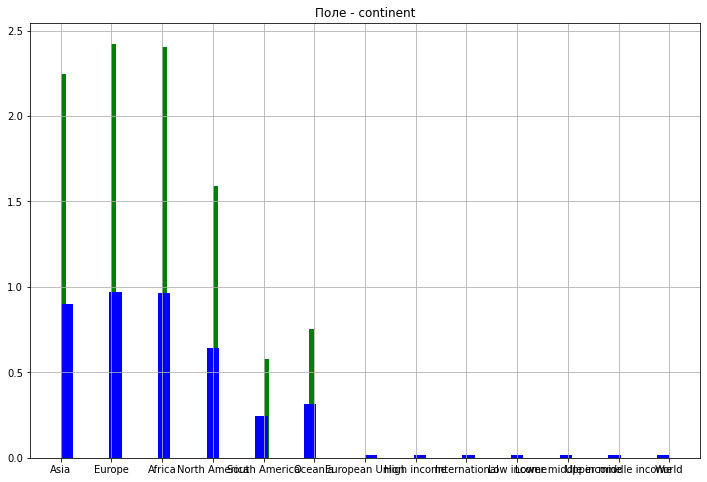

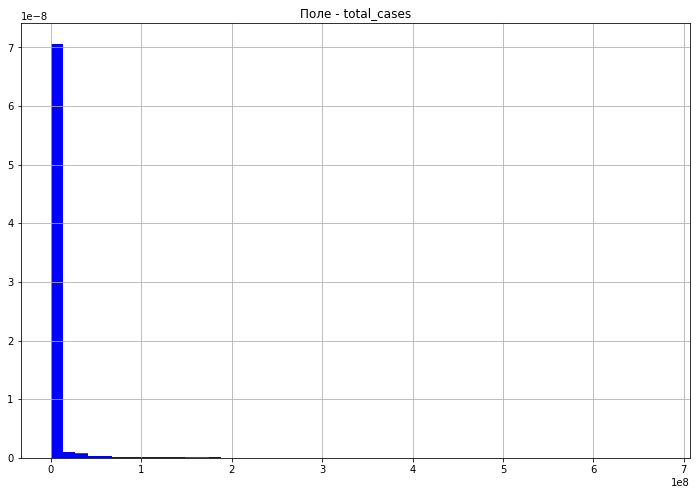

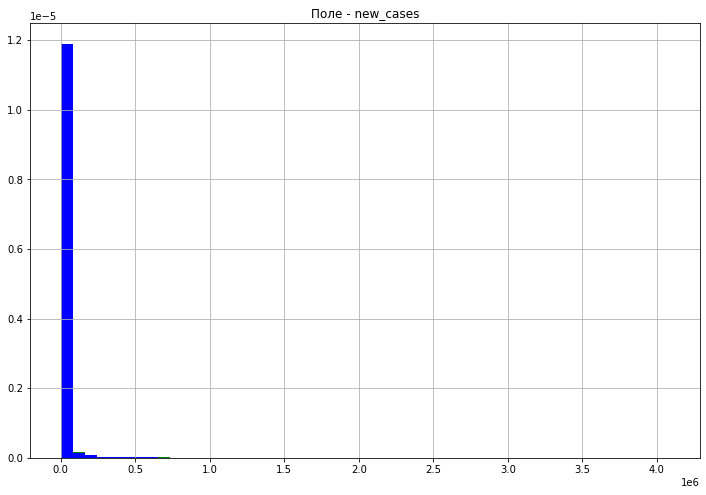

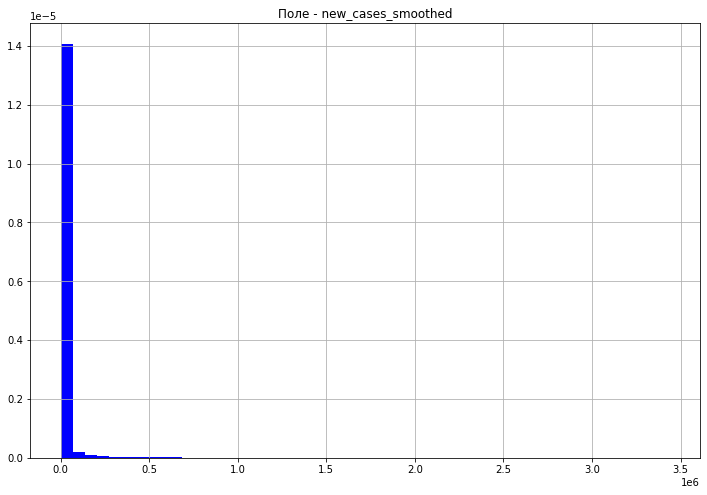

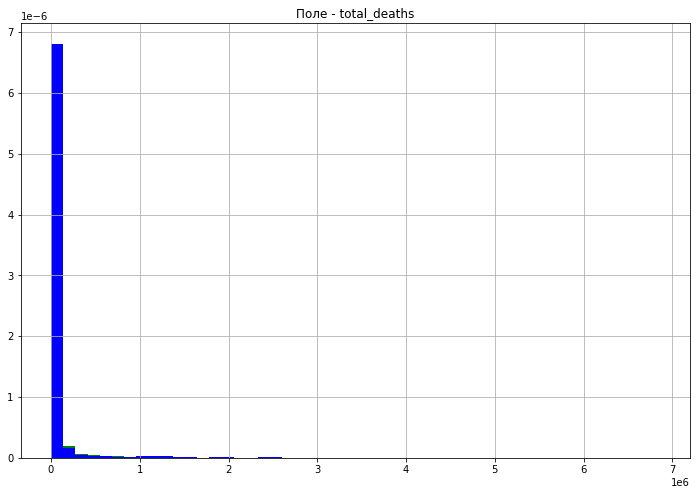

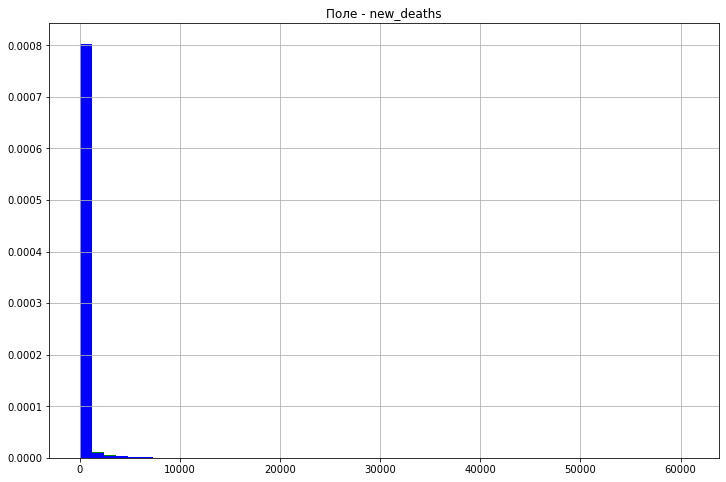

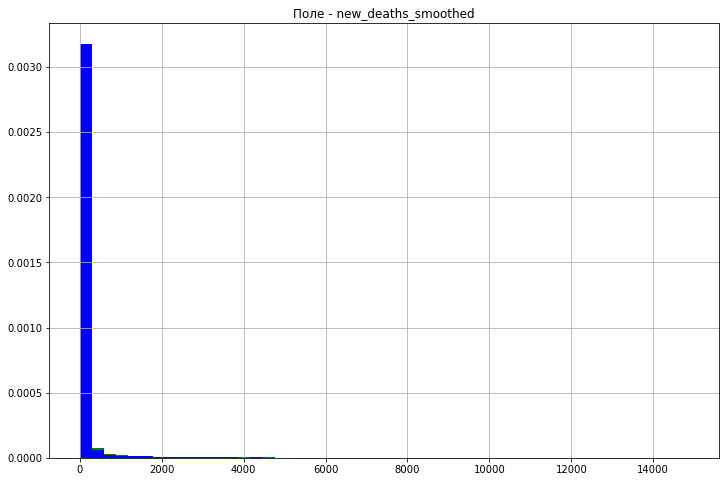

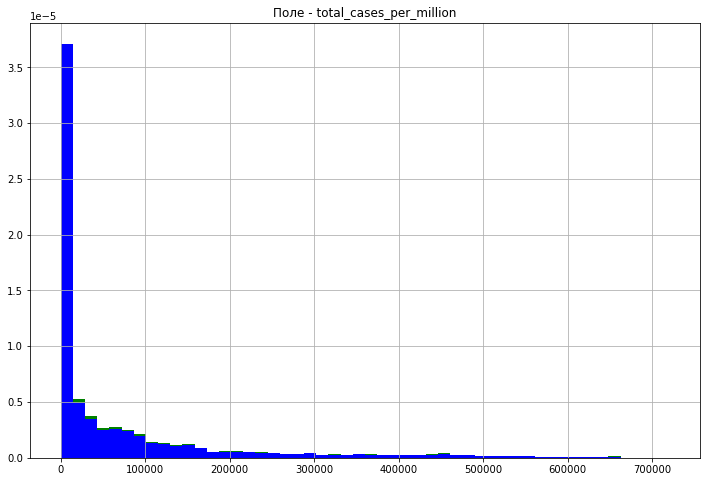

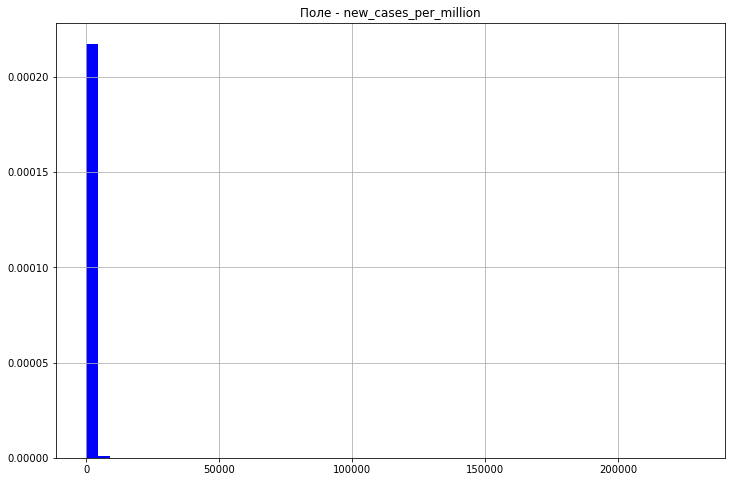

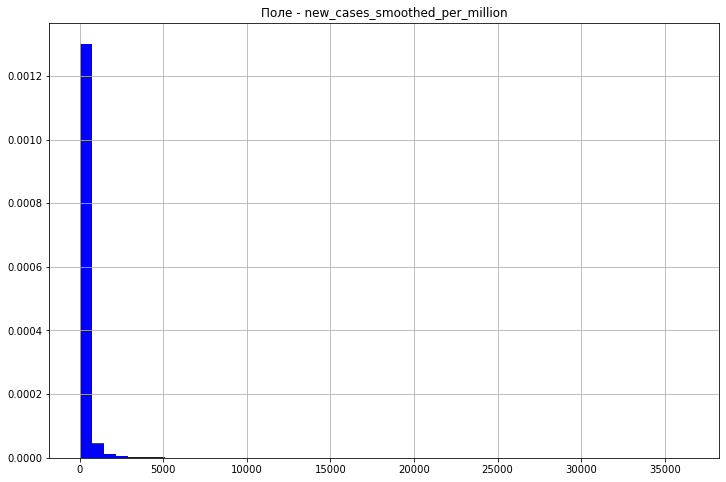

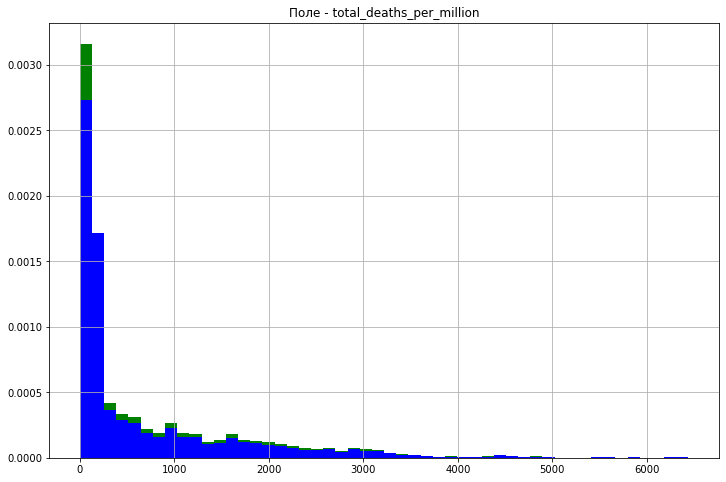

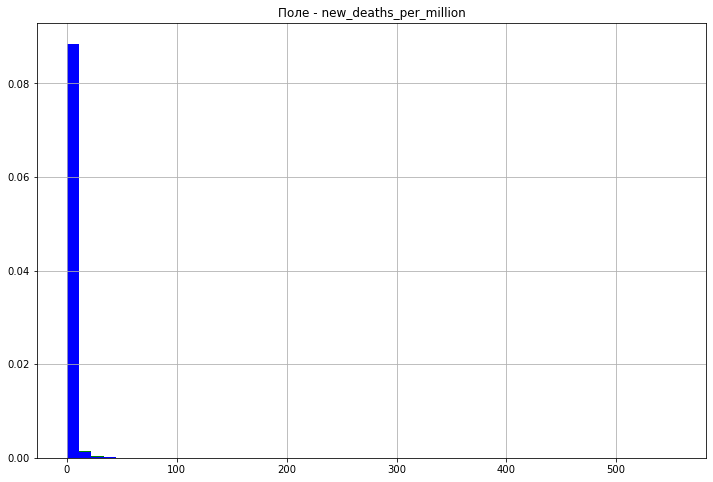

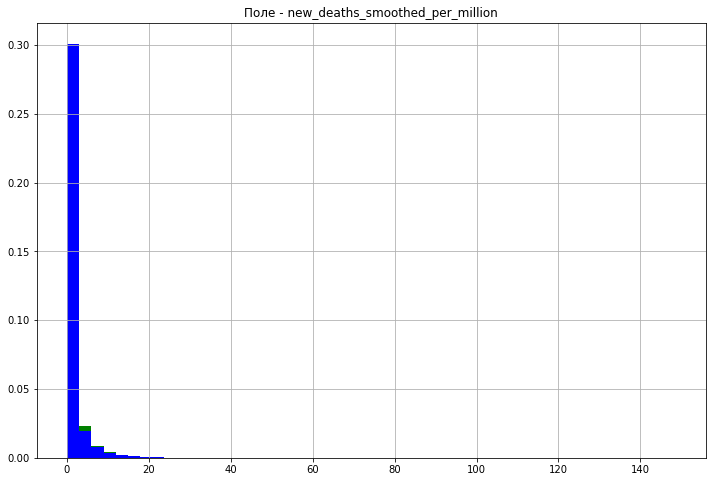

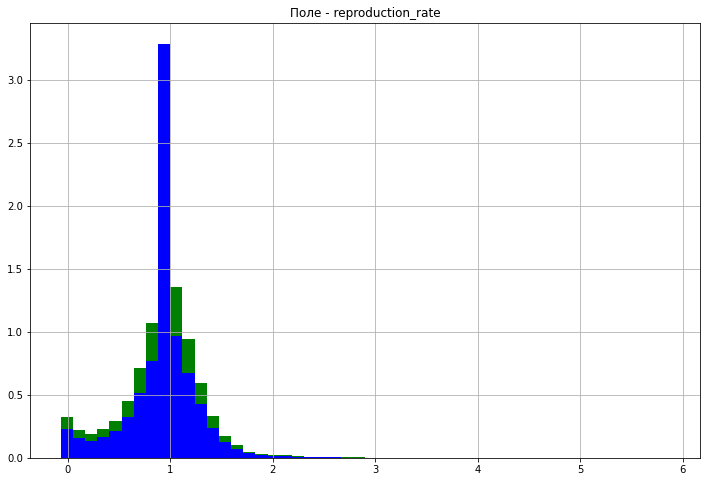

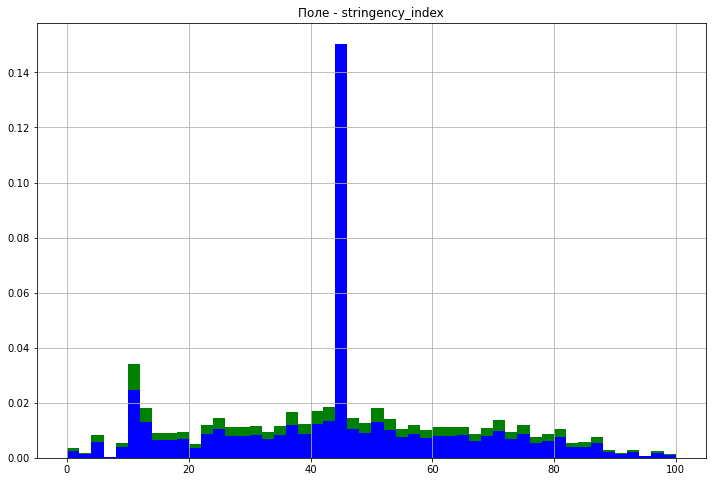

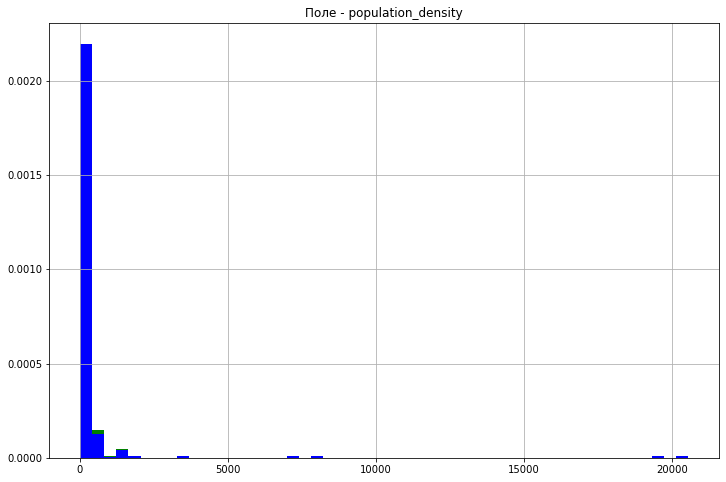

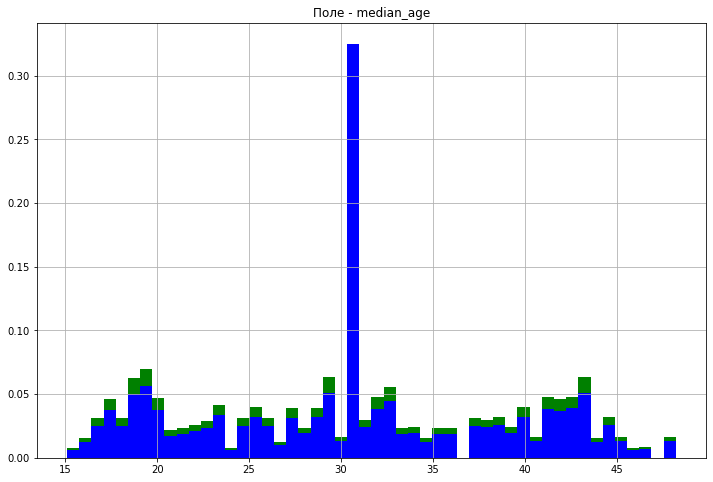

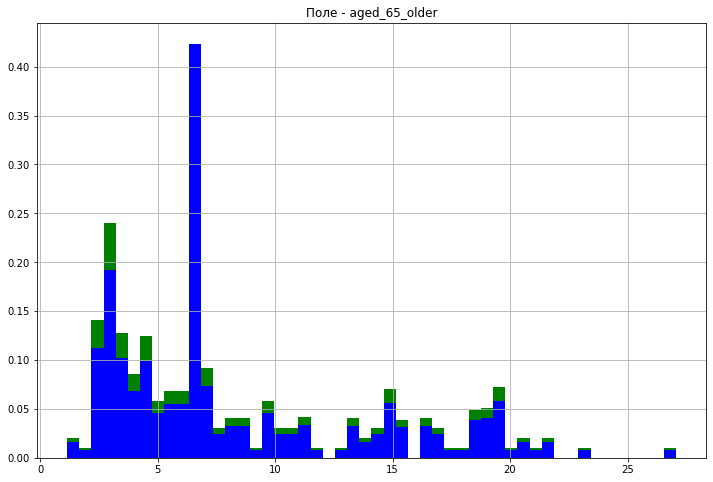

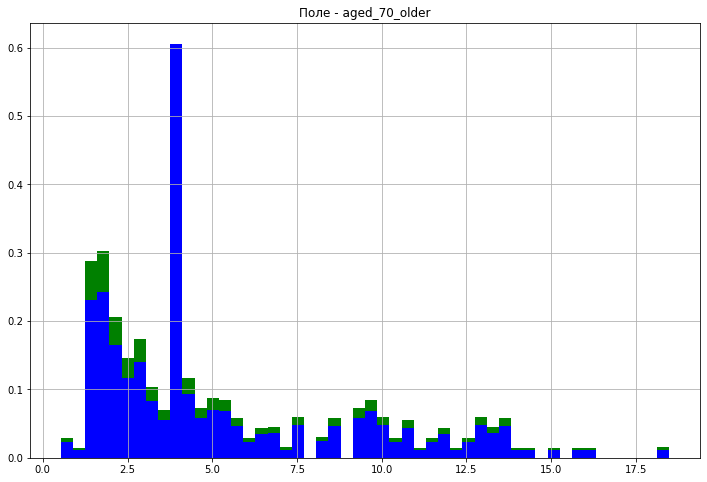

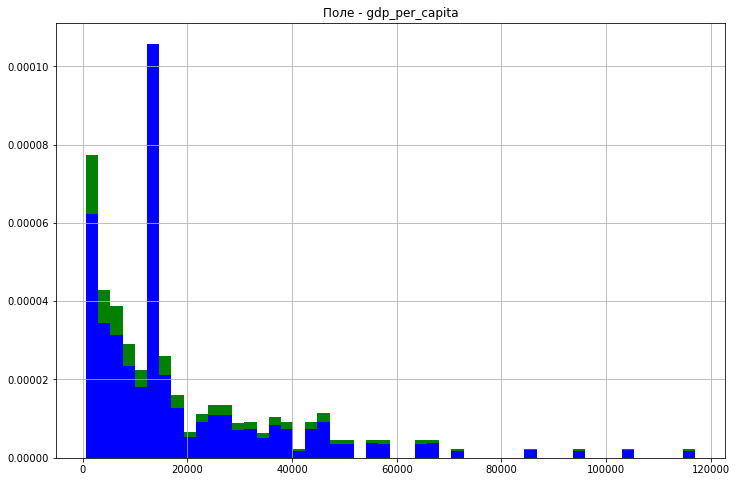

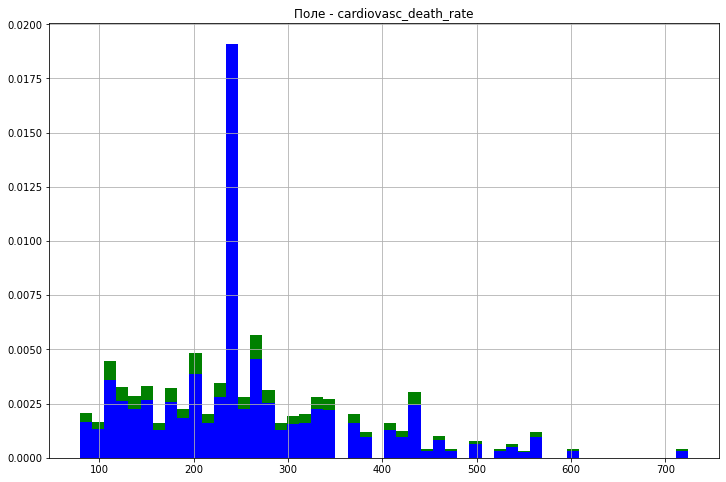

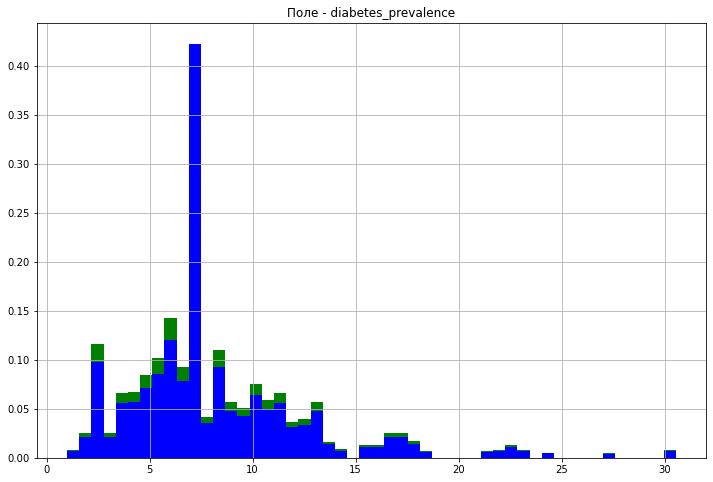

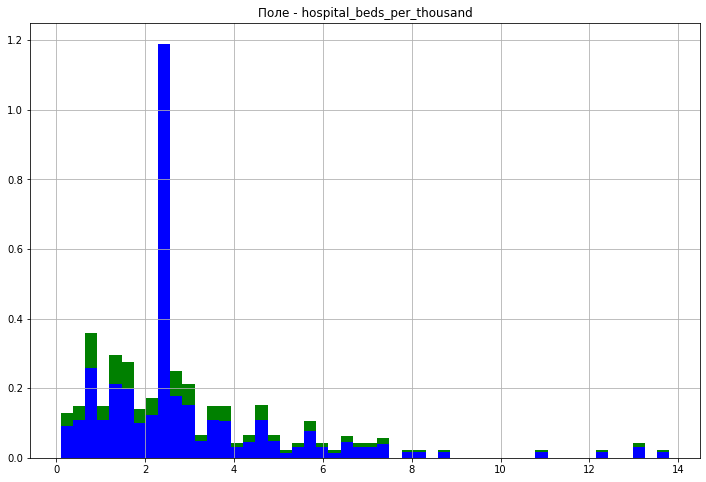

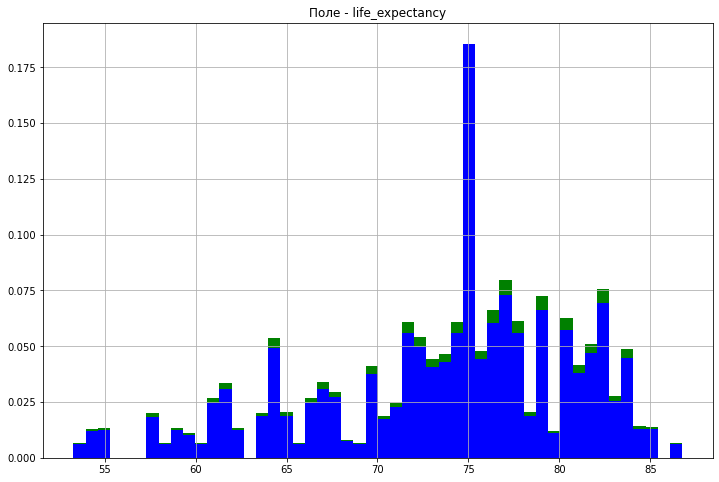

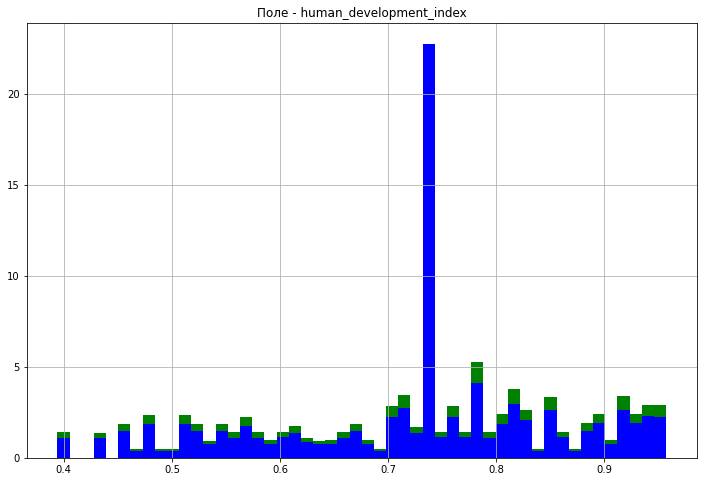

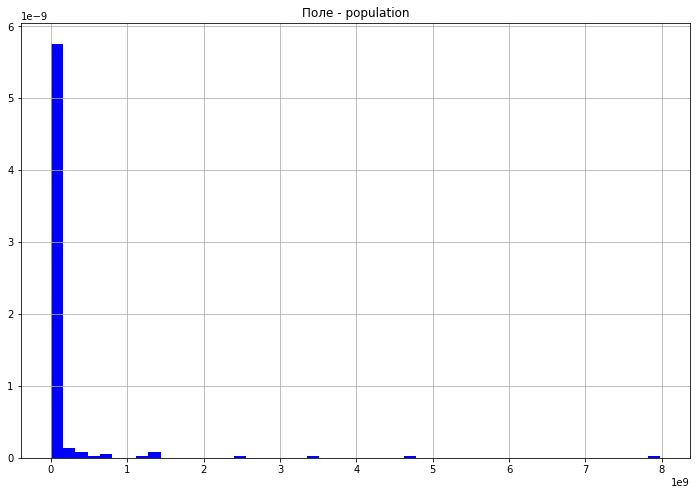

In [38]:
plot_hist_diff(covid2, covid2_drop, hcols_with_na)

#### Преобразование категориальных признаков в числовые

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le1 = LabelEncoder()
covid2_drop["continent"] = le1.fit_transform(covid2_drop["continent"].astype('str'))

In [41]:
le1.classes_

array(['Africa', 'Asia', 'Europe', 'European Union', 'High income',
       'International', 'Low income', 'Lower middle income',
       'North America', 'Oceania', 'South America', 'Upper middle income',
       'World'], dtype=object)

In [42]:
le2 = LabelEncoder()
covid2_drop["location"] = le2.fit_transform(covid2_drop["location"].astype('str'))

In [43]:
le2.classes_

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswat

In [44]:
le3 = LabelEncoder()
covid2_drop["iso_code"] = le3.fit_transform(covid2_drop["iso_code"].astype('str'))

In [46]:
le3.classes_

array(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL',
       'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV',
       'CRI', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA',
       'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST',
       'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR',
       'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR',
       'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM',
       'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA',
       'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO',
       'MDA', 'MDG',

In [207]:
covid2_drop["iso_code"].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: iso_code, dtype: int32

In [47]:
covid2_drop['Date'] = pd.to_datetime(covid2_drop['date'],format='%Y-%m-%d')

In [48]:
covid2_drop = covid2_drop.drop(['date'], axis = 1)

In [49]:
covid3 = covid2_drop.copy(deep=True)

In [51]:
covid3.head(10)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,Date
0,1,1,0,5.0,5.0,77.857,1358.0,0.0,1.143,0.122,0.122,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-24
1,1,1,0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-25
2,1,1,0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-26
3,1,1,0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-27
4,1,1,0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-28
5,1,1,0,5.0,0.0,0.714,1358.0,0.0,1.143,0.122,0.000,0.017,248.8685,0.0,0.158,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-29
6,1,1,0,5.0,0.0,0.714,1358.0,0.0,1.143,0.122,0.000,0.017,248.8685,0.0,0.158,0.95,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-01
7,1,1,0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-02
8,1,1,0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-03
9,1,1,0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-04


In [234]:
covid2_drop

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,Date
0,1,1,0,5.0,5.0,76.143,1361.0,0.0,1.143,0.122,0.122,15.772,252.5295,0.0,0.154,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-24
1,1,1,0,5.0,0.0,76.143,1361.0,0.0,1.143,0.122,0.000,15.772,252.5295,0.0,0.154,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-25
2,1,1,0,5.0,0.0,76.143,1361.0,0.0,1.143,0.122,0.000,15.772,252.5295,0.0,0.154,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-26
3,1,1,0,5.0,0.0,76.143,1361.0,0.0,1.143,0.122,0.000,15.772,252.5295,0.0,0.154,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-27
4,1,1,0,5.0,0.0,76.143,1361.0,0.0,1.143,0.122,0.000,15.772,252.5295,0.0,0.154,0.95,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260562,247,0,247,263921.0,36.0,76.143,5663.0,0.0,0.143,16171.096,4.604,15.772,346.9860,0.0,0.009,0.95,44.44,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,1.7,61.49,0.571,16320539.0,2023-02-23
260563,247,0,247,263921.0,36.0,76.143,5663.0,0.0,0.143,16171.096,4.604,15.772,346.9860,0.0,0.009,0.95,44.44,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,1.7,61.49,0.571,16320539.0,2023-02-24
260564,247,0,247,263921.0,36.0,76.143,5663.0,0.0,0.143,16171.096,4.604,15.772,346.9860,0.0,0.009,0.95,44.44,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,1.7,61.49,0.571,16320539.0,2023-02-25
260565,247,0,247,263921.0,36.0,76.143,5663.0,0.0,0.143,16171.096,4.604,15.772,346.9860,0.0,0.009,0.95,44.44,42.729,19.6,2.822,1.882,1899.775,307.846,1.82,1.7,61.49,0.571,16320539.0,2023-02-26


#### Отбор признаков

Задача отбора признаков - выбрать признаки, наиболее полезные для дальнейшего построения модели.
- Простые модели (с меньшим количеством признаков) легче интерпретировать.
- Модели хуже обучаются на датасетах с большим количеством признаков. 
- Уменьшение времени обучения и предсказания.
- Уменьшение риска переобучения.

#### Метод фильтрации

VarianceThreshold Селектор функций, который удаляет все функции с низкой дисперсией. Функции с дисперсией тренировочного набора ниже порога будут удалены.

In [52]:
from sklearn.feature_selection import VarianceThreshold

In [53]:
selector = VarianceThreshold(threshold=0.15)
selector.fit(covid3.drop(['Date'], axis = 1))
# Значения дисперсий для каждого признака
selector.variances_

array([5.11471730e+03, 1.32457264e+01, 5.10330413e+03, 9.93758138e+14,
       6.37468909e+09, 5.99600999e+09, 1.43903786e+11, 4.74719704e+05,
       4.06084220e+05, 1.45998194e+10, 1.19785624e+06, 4.18391450e+05,
       9.41830307e+05, 2.11079177e+01, 8.80271614e+00, 1.14989294e-01,
       4.03739606e+02, 3.86545232e+06, 6.61778257e+01, 3.06309903e+01,
       1.42266042e+01, 3.45547174e+08, 1.16918667e+04, 1.92656812e+01,
       4.73507064e+00, 5.10493054e+01, 1.76195082e-02, 4.76467377e+17])

In [55]:
covid2_drop.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population', 'Date'],
      dtype='object')

In [56]:
col = ['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
        'population']
covid3 = pd.DataFrame(selector.transform(covid2_drop.drop(['Date'], axis = 1)), columns=col)

In [57]:
covid3.shape

(257737, 26)

In [58]:
covid3.head(10)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,population
0,1.0,1.0,0.0,5.0,5.0,77.857,1358.0,0.0,1.143,0.122,0.122,16.174,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
1,1.0,1.0,0.0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
2,1.0,1.0,0.0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
3,1.0,1.0,0.0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
4,1.0,1.0,0.0,5.0,0.0,77.857,1358.0,0.0,1.143,0.122,0.000,16.174,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
5,1.0,1.0,0.0,5.0,0.0,0.714,1358.0,0.0,1.143,0.122,0.000,0.017,248.8685,0.0,0.158,8.33,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
6,1.0,1.0,0.0,5.0,0.0,0.714,1358.0,0.0,1.143,0.122,0.000,0.017,248.8685,0.0,0.158,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
7,1.0,1.0,0.0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
8,1.0,1.0,0.0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0
9,1.0,1.0,0.0,5.0,0.0,0.000,1358.0,0.0,1.143,0.122,0.000,0.000,248.8685,0.0,0.158,27.78,54.422,18.6,2.581,1.337,1803.987,597.029,9.59,0.5,64.83,41128772.0


### Методы, основанные на корреляции

- Желательно, чтобы признаки хорошо коррелировали с целевым признаком.
- Важно, чтобы признаки не коррелировали между собой.

Коэффициент корреляции (удаляются признаки, у которых коэффициент корреляции больше порогового). Этот алгоритм выбора функций рассматривает только функции (X), а не желаемые результаты (y), и поэтому может использоваться для обучения без учителя.

<AxesSubplot:>

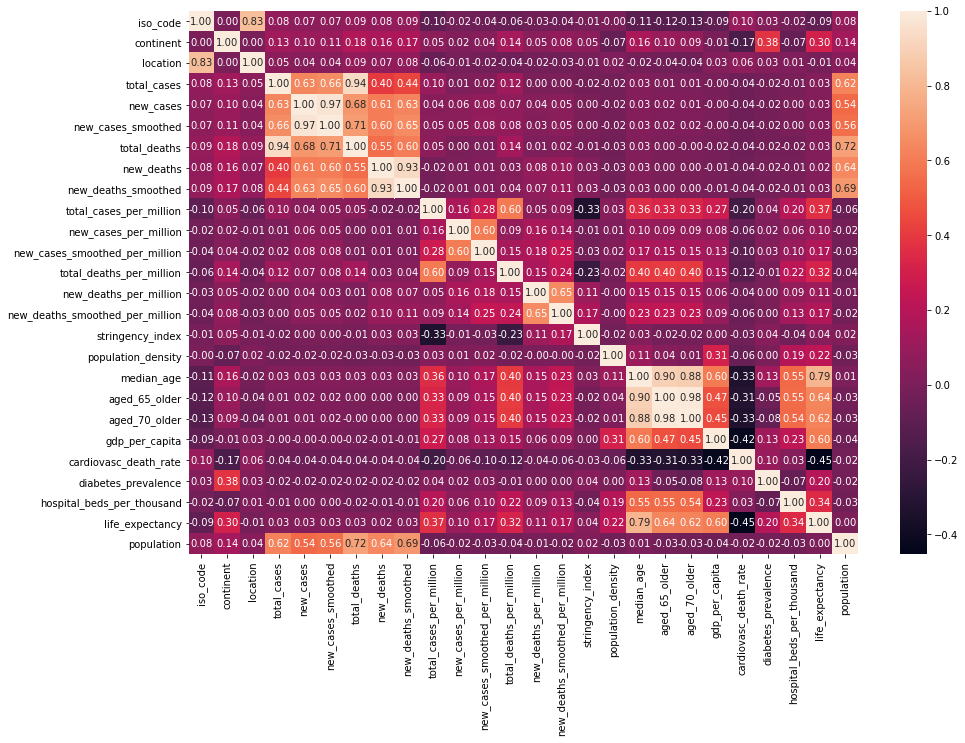

In [59]:
plt.figure(figsize= (15, 10))
sns.heatmap(covid3.corr(), annot=True, fmt='.2f')

In [60]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [61]:
make_corr_df(covid3)

,f1,f2,corr
0,aged_70_older,aged_65_older,0.983149
1,aged_65_older,aged_70_older,0.983149
2,new_cases_smoothed,new_cases,0.968114
3,new_cases,new_cases_smoothed,0.968114
4,total_cases,total_deaths,0.936436
5,total_deaths,total_cases,0.936436
6,new_deaths_smoothed,new_deaths,0.927120
7,new_deaths,new_deaths_smoothed,0.927120
8,median_age,aged_65_older,0.895080
9,aged_65_older,median_age,0.895080


In [62]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [63]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(covid3))

[['aged_65_older', 'median_age', 'aged_70_older'],
 ['new_cases', 'new_cases_smoothed'],
 ['total_deaths', 'total_cases'],
 ['new_deaths', 'new_deaths_smoothed'],
 ['location', 'iso_code']]

In [64]:
covid3 = covid2_drop.drop(['median_age', 'aged_70_older', 'new_cases_smoothed', 'new_deaths_smoothed', 'iso_code'], axis = 1)

In [65]:
covid3.shape

(257737, 24)

In [66]:
covid3.head(10)

,continent,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,Date
0,1,0,5.0,5.0,1358.0,0.0,0.122,0.122,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-24
1,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-25
2,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-26
3,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-27
4,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,16.174,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-28
5,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,0.017,248.8685,0.0,0.158,0.95,8.33,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-02-29
6,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,0.017,248.8685,0.0,0.158,0.95,27.78,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-01
7,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-02
8,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-03
9,1,0,5.0,0.0,1358.0,0.0,0.122,0.000,0.000,248.8685,0.0,0.158,0.95,27.78,54.422,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,41128772.0,2020-03-04


### 1.3 Описание структуры набора данных

#### Описание набора данных

__iso_code__ - ISO 3166-1 alpha-3 – трехбуквенные коды стран. Обратите внимание, что регионы, определенные OWID (например, континенты, такие как «Европа»), содержат префикс «OWID_».

__continent__ - Континент географического положения

__location__ - Географическое положение. Локация «Интернешнл» учитывает особые регионы (круизы «Бриллиантовая принцесса» и «MS Zaandam»).

__date__ - Дата наблюдения

__total_cases__ - Всего подтвержденных случаев COVID-19. Подсчеты могут включать вероятные случаи, о которых сообщалось.

__new_cases__ - Новые подтвержденные случаи COVID-19. Подсчеты могут включать вероятные случаи, о которых сообщалось. В редких случаях, когда наш источник сообщает об отрицательных ежедневных изменениях из-за коррекции данных, мы устанавливаем для этой метрики значение NA.

__new_cases_smoothed__ - Новые подтвержденные случаи COVID-19 (7-дневные сглаженные). Подсчеты могут включать вероятные случаи, о которых сообщалось.

__total_cases_per_million__ - Всего подтвержденных случаев COVID-19 на 1 000 000 человек. Подсчеты могут включать вероятные случаи, о которых сообщалось.

__new_cases_per_million__ - Новые подтвержденные случаи COVID-19 на 1 000 000 человек. Подсчеты могут включать вероятные случаи, о которых сообщалось.

__new_cases_smoothed_per_million__ - Новые подтвержденные случаи COVID-19 (7-дневные сглаженные) на 1 000 000 человек. Подсчеты могут включать вероятные случаи, о которых сообщалось.

__total_deaths__ - Общее количество смертей связано с COVID-19. Подсчеты могут включать вероятные случаи смерти, о которых сообщается.

__new_deaths__ - Новые смертельные случаи связаны с COVID-19. Подсчеты могут включать вероятные случаи смерти, о которых сообщается. В редких случаях, когда наш источник сообщает об отрицательных ежедневных изменениях из-за коррекции данных, мы устанавливаем для этой метрики значение NA.

__new_deaths_smoothed__ - Новые смертельные случаи, связанные с COVID-19 (7-дневные сглажены). Подсчеты могут включать вероятные случаи смерти, о которых сообщается.

__total_deaths_per_million__ - Общее количество смертей, связанных с COVID-19, на 1 000 000 человек. Подсчеты могут включать вероятные случаи смерти, о которых сообщается.

__new_deaths_per_million__ - Новые смертельные случаи связаны с COVID-19 на 1 000 000 человек. Подсчеты могут включать вероятные случаи смерти, о которых сообщается.

__new_deaths_smoothed_per_million__ - Новые смертельные случаи, связанные с COVID-19 (7-дневные сглаженные) на 1 000 000 человек. Подсчеты могут включать вероятные случаи смерти, о которых сообщается.

__excess_mortality__ - Процентная разница между зарегистрированным числом еженедельных или ежемесячных смертей в 2020–2021 годах и прогнозируемым числом смертей за тот же период на основе предыдущих лет.

__excess_mortality_cumulative__ - Процентная разница между совокупным числом смертей с 1 января 2020 года и кумулятивной прогнозируемой смертностью за тот же период на основе предыдущих лет. 

__excess_mortality_cumulative_absolute__ - Кумулятивная разница между зарегистрированным числом смертей с 1 января 2020 года и прогнозируемым числом смертей за тот же период на основе предыдущих лет. 

__excess_mortality_cumulative_per_million__ - Кумулятивная разница между зарегистрированным числом смертей с 1 января 2020 года и прогнозируемым числом смертей за тот же период на основе предыдущих лет на миллион человек. 

__icu_patients__ - Количество пациентов с COVID-19 в отделениях интенсивной терапии (ОИТ) в данный день

__icu_patients_per_million__ - Количество пациентов с COVID-19 в отделениях интенсивной терапии (ОИТ) в данный день на 1 000 000 человек

__hosp_patients__ - Количество пациентов с COVID-19 в больнице в данный день

__hosp_patients_per_million__ - Количество пациентов с COVID-19 в больнице в данный день на 1 000 000 человек

__weekly_icu_admissions__ - Число пациентов с COVID-19, вновь поступивших в отделения интенсивной терапии (ОИТ) за определенную неделю (отчетная дата и предшествующие 6 дней)

__weekly_icu_admissions_per_million__ - Число пациентов с COVID-19, вновь поступивших в отделения интенсивной терапии (ОИТ) в течение определенной недели на 1 000 000 человек (отчетная дата и предшествующие 6 дней)

__weekly_hosp_admissions__ - Число пациентов с COVID-19, вновь поступивших в больницы за данную неделю (отчетная дата и предшествующие 6 дней)

__weekly_hosp_admissions_per_million__ - Число пациентов с COVID-19, вновь поступивших в больницы в течение определенной недели на 1 000 000 человек (отчетная дата и предшествующие 6 дней)

__stringency_index__ - Индекс жесткости ответных мер правительства: сводный показатель, основанный на 9 показателях реагирования, включая закрытие школ, закрытие рабочих мест и запреты на поездки, измененный до значения от 0 до 100 (100 = самый строгий ответ)

__reproduction_rate__ - Оценка эффективного коэффициента воспроизводства (R) COVID-19 в режиме реального времени.

__total_tests__ - Всего тестов на COVID-19

__new_tests__ - Новые тесты на COVID-19 (рассчитаны только на последовательные дни)

__total_tests_per_thousand__ - Всего тестов на COVID-19 на 1 человек

__new_tests_per_thousand__ - Новые тесты на COVID-19 на 1 человек

__new_tests_smoothed__ - Новые тесты на COVID-19 (7-дневные сглаженные). Для стран, которые не сообщают данные тестирования на ежедневной основе, мы предполагаем, что тестирование менялось одинаково ежедневно в течение любых периодов, в течение которых данные не были представлены. Это дает полную серию ежедневных цифр, которые затем усредняются за скользящее 7-дневное окно.

__new_tests_smoothed_per_thousand__ - Новые тесты на COVID-19 (7-дневные сглаженные) на 1 человек

__positive_rate__ - Доля положительных тестов на COVID-19 приведена в виде скользящего 7-дневного среднего значения (это обратная tests_per_case)

__tests_per_case__ - Тесты, проведенные на новый подтвержденный случай COVID-19, приведены как скользящее 7-дневное среднее значение (это обратная positive_rate).

__tests_units__ - Единицы измерения, используемые местоположением для представления данных тестирования. Файл страны не может содержать смешанные единицы измерения. Все метрики, касающиеся данных тестирования, используют указанную единицу измерения. Действительными единицами являются «протестированные люди» (количество протестированных людей), «выполненные тесты» (количество выполненных тестов. один человек может быть протестирован более одного раза в данный день) и «проверенные образцы» (количество протестированных образцов). В некоторых случаях для выполнения данного теста может потребоваться более одного образца.)

__total_vaccinations__ - Общее количество введенных доз вакцинации против COVID-19

__people_vaccinated__ - Общее число людей, получивших хотя бы одну дозу вакцины

__people_fully_vaccinated__ - Общее количество людей, получивших все дозы, назначенные протоколом первичной вакцинации

__total_boosters__ - Общее количество введенных доз бустера вакцинации против COVID-19 (дозы, введенные сверх количества, предписанного протоколом вакцинации)

__new_vaccinations__ - Новые дозы вакцинации против COVID-19 (рассчитаны только на последовательные дни)

__new_vaccinations_smoothed__ - Введены новые дозы вакцинации против COVID-19 (7-дневные сглаженные). Для стран, которые не сообщают данные о вакцинации на ежедневной основе, мы предполагаем, что вакцинация менялась одинаково на ежедневной основе в течение любых периодов, в течение которых данные не были представлены. Это дает полную серию ежедневных цифр, которые затем усредняются за скользящее 7-дневное окно.

__total_vaccinations_per_hundred__ - Общее количество введенных доз вакцинации от COVID-19 на 100 человек в общей численности населения

__people_vaccinated_per_hundred__ - Общее число людей, получивших хотя бы одну дозу вакцины на 100 человек в общей численности населения

__people_fully_vaccinated_per_hundred__ - Общее количество людей, получивших все дозы, назначенные протоколом первичной вакцинации, на 100 человек в общей численности населения

__total_boosters_per_hundred__ - Общее количество введенных бустерных доз вакцинации против COVID-19 на 100 человек в общей численности населения

__new_vaccinations_smoothed_per_million__ - Новые дозы вакцинации против COVID-19 (7-дневные сглаженные) на 1 000 000 человек в общей численности населения

__new_people_vaccinated_smoothed__ - Ежедневное количество людей, получающих первую дозу вакцины (7-дневная сглаженная)

__new_people_vaccinated_smoothed_per_hundred__ - Ежедневное число людей, получающих первую дозу вакцины (7-дневную сглаженную) на 100 человек в общей численности населения

__population__ - Население (последние доступные значения). 

__population_density__ - Количество людей, разделенных на площадь земли, измеряемое в квадратных километрах, последний доступный год

__median_age__ - Средний возраст населения, прогноз ООН на 2020 год

__aged_65_older__ - Доля населения в возрасте 65 лет и старше, последний год доступен

__aged_70_older__ - Доля населения в возрасте 70 лет и старше в 2015 году

__gdp_per_capita__ - Валовой внутренний продукт по паритету покупательной способности (постоянные международные доллары 2011 года), последний доступный год

__extreme_poverty__ - Доля населения, живущего в условиях крайней нищеты, последний год доступен с 2010 года

__cardiovasc_death_rate__ - Смертность от сердечно-сосудистых заболеваний в 2017 году (ежегодное число смертей на 100 000 человек)

__diabetes_prevalence__ - Распространенность диабета (% населения в возрасте от 20 до 79 лет) в 2017 году

__female_smokers__ - Доля курящих женщин, последний год

__male_smokers__ - Доля мужчин, которые курят, последний год доступен

__handwashing_facilities__ - Доля населения, имеющего основные средства для мытья рук в помещениях, последний год доступен

__hospital_beds_per_thousand__ - Больничные койки на 1 человек, последний год доступен с 000 года

__life_expectancy__ - Ожидаемая продолжительность жизни при рождении в 2019 году

__human_development_index__ - Сводный индекс, измеряющий средние достижения по трем основным измерениям человеческого развития — долгой и здоровой жизни, знаниям и достойному уровню жизни. Значения за 2019 год


In [21]:
# Ссылка на описание набора данных https://docs.owid.io/projects/covid/en/latest/dataset.html

In [67]:
# Вывод Вещественных значений с фиксированной точкой
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

In [68]:
covid3.describe().T

,count,mean,std,min,25%,50%,75%,max
continent,257737.0000,3.3942,3.6395,0.0000,1.0000,2.0000,8.0000,12.0000
location,257737.0000,121.4076,71.4376,0.0000,60.0000,121.0000,184.0000,247.0000
total_cases,257737.0000,4977799.6445,31523990.7671,1.0000,6524.0000,61890.0000,548571.0000,673340534.0000
new_cases,257737.0000,11141.1620,79841.8050,0.0000,0.0000,38.0000,694.0000,4082888.0000
total_deaths,257737.0000,69347.0908,379347.2603,1.0000,163.0000,1358.0000,8045.0000,6857231.0000
new_deaths,257737.0000,110.5494,689.0004,0.0000,0.0000,0.0000,7.0000,60788.0000
total_cases_per_million,257737.0000,69681.7189,120829.9470,0.0010,1599.4420,13927.8100,80254.1230,720435.2200
new_cases_per_million,257737.0000,167.6437,1094.4683,0.0000,0.0000,4.8590,72.4570,228872.0250
new_cases_smoothed_per_million,257737.0000,168.0529,646.8331,0.0000,1.2200,16.1740,108.3360,36421.8270
total_deaths_per_million,257737.0000,682.7577,970.4813,0.0000,53.3210,248.8685,955.8780,6440.4010


#### Плотность распределения данных

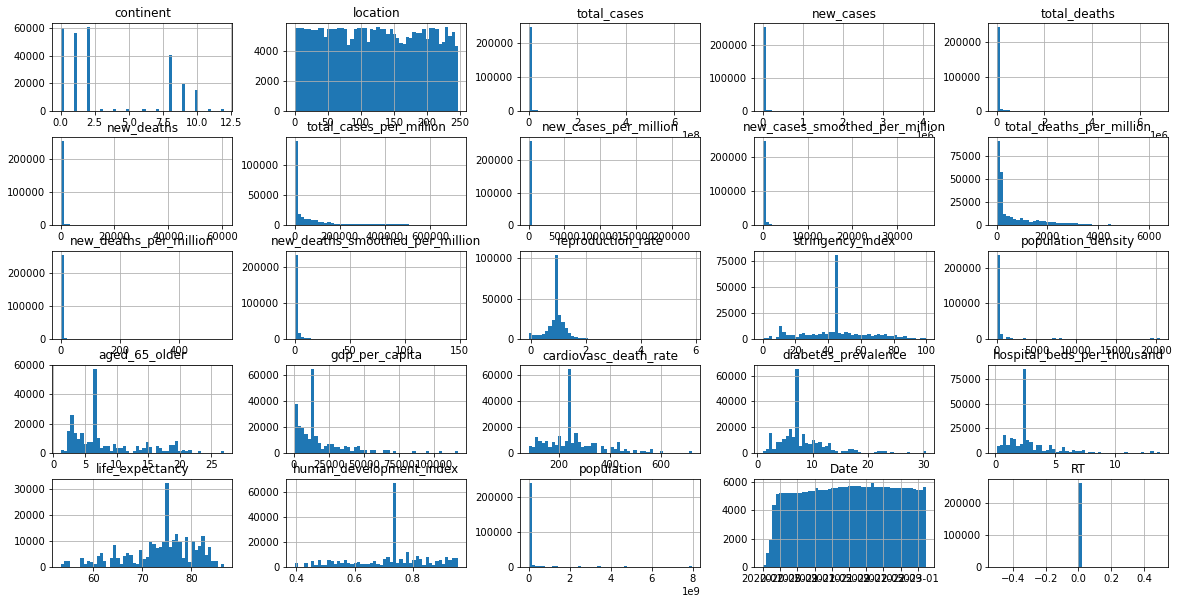

In [275]:
covid3.hist(figsize = (20,10), bins = 50);

### 1.4 Формирование дополнительных атрибутов

Коэффициент распространения коронавируса (Rt) - это показатель, определяющий среднее количество людей, которых инфицирует один больной до его изоляции. Он рассчитывается на основе данных по приросту новых случаев за последние 8 суток. Коэффициент распространения коронавируса используется для принятия решений о переходе к первому, второму или третьему этапу снятия ограничений.

In [69]:
covid3['RT']= 0.0

In [70]:
%%time
for i in range(len(covid3)-8):
    loc = covid3['location'][i]
    if(covid3['location'][i+8] == loc):
        covid3['RT'][i+8] = (covid3['total_cases'][i+7]+covid3['total_cases'][i+6]+covid3['total_cases'][i+5]+covid3['total_cases'][i+4])/(covid3['total_cases'][i+3]+covid3['total_cases'][i+2]+covid3['total_cases'][i+1]+covid3['total_cases'][i])
    else:
        for j in range(8):
            covid3['RT'][i] = 0
            i += 1

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 1min 35s


Для принятия решения о поэтапном снятии ограничений в регионах коэффициент распространения коронавируса используется наряду с данными о свободном коечным фондом и показателем тестирования на 100 тыс. населения. Одно из условий перехода к первому этапу снятия режима самоизоляции - это снижение показателя Rt ниже единицы.

Простыми словами, коэффициент распространения коронавируса показывает, сколько человек в среднем успевает заразить один инфицированный до его изоляции. Согласно рекомендациям Роспотребнадзора, регионы, где показатель Rt равен или меньше 1, могут приступать к смягчению ограничительных мер из-за коронавируса. Если коэффициент снижается до 0,8 и менее, регион может перейти ко второму этапу, при значении 0,5 и менее - к третьему.

In [71]:
covid3.head(100)

,continent,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,Date,RT
0,1,0,5.0000,5.0000,1358.0000,0.0000,0.1220,0.1220,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-24,0.0000
1,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-25,0.0000
2,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-26,0.0000
3,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-27,0.0000
4,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-28,0.0000
5,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,0.0170,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-02-29,0.0000
6,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,0.0170,248.8685,0.0000,0.1580,0.9500,27.7800,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-03-01,0.0000
7,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,0.0000,248.8685,0.0000,0.1580,0.9500,27.7800,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-03-02,0.0000
8,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,0.0000,248.8685,0.0000,0.1580,0.9500,27.7800,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-03-03,1.0000
9,1,0,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,0.0000,248.8685,0.0000,0.1580,0.9500,27.7800,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,2020-03-04,1.0000


### 1.5 Кластеризация набора данных

In [72]:
df = covid3.drop(['Date','continent','location'], axis = 1)
df.head()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,RT
0,5.0000,5.0000,1358.0000,0.0000,0.1220,0.1220,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,0.0000
1,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,0.0000
2,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,0.0000
3,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,0.0000
4,5.0000,0.0000,1358.0000,0.0000,0.1220,0.0000,16.1740,248.8685,0.0000,0.1580,0.9500,8.3300,54.4220,2.5810,1803.9870,597.0290,9.5900,0.5000,64.8300,0.5110,41128772.0000,0.0000


In [73]:
# Скалирование данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
X_scale = scaler.transform(df)
scaled_data = pd.DataFrame(X_scale, columns=df.columns)

In [74]:
scaled_data.head()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,RT
0,-0.1579,-0.1395,-0.1792,-0.1604,-0.5767,-0.1531,-0.2348,-0.4471,-0.2395,-0.3231,0.0814,-1.8131,-0.1800,-1.0410,-0.8832,3.1327,0.3144,-1.1131,-1.2439,-1.6370,-0.1432,-2.0457
1,-0.1579,-0.1395,-0.1792,-0.1604,-0.5767,-0.1532,-0.2348,-0.4471,-0.2395,-0.3231,0.0814,-1.8131,-0.1800,-1.0410,-0.8832,3.1327,0.3144,-1.1131,-1.2439,-1.6370,-0.1432,-2.0457
2,-0.1579,-0.1395,-0.1792,-0.1604,-0.5767,-0.1532,-0.2348,-0.4471,-0.2395,-0.3231,0.0814,-1.8131,-0.1800,-1.0410,-0.8832,3.1327,0.3144,-1.1131,-1.2439,-1.6370,-0.1432,-2.0457
3,-0.1579,-0.1395,-0.1792,-0.1604,-0.5767,-0.1532,-0.2348,-0.4471,-0.2395,-0.3231,0.0814,-1.8131,-0.1800,-1.0410,-0.8832,3.1327,0.3144,-1.1131,-1.2439,-1.6370,-0.1432,-2.0457
4,-0.1579,-0.1395,-0.1792,-0.1604,-0.5767,-0.1532,-0.2348,-0.4471,-0.2395,-0.3231,0.0814,-1.8131,-0.1800,-1.0410,-0.8832,3.1327,0.3144,-1.1131,-1.2439,-1.6370,-0.1432,-2.0457


In [75]:
# Уменьшение размерности датафрейма до 2-х измерений
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)
np.shape(x_pca)

(257737, 2)

Определение наилучшего количества кластеров по "методу локтя"

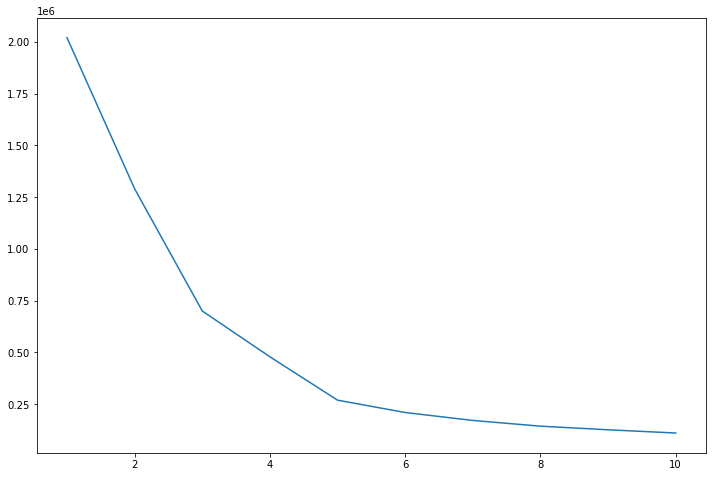

In [76]:
from sklearn.cluster import KMeans
wgcc = []
for i in range(1,11):
    kmean = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmean.fit(x_pca)
    wgcc.append(kmean.inertia_)
plt.plot(range(1,11), wgcc);

### Кластеризация

Будут использоваться такие модели кластеризации как Kmeans, Birch и GaussianMixture, так как позволяют работать с большими объемами данных и выбирать количество кластеров.

__kmeans__ разбивает множество элементов векторного пространства на заранее известное число кластеров k.

Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике

__Birch__ - это алгоритм интеллектуального анализа данных без учителя, используемый для осуществления иерархической кластеризации на наборах данных большого размера. Преимуществом BIRCH является возможность метода динамически кластеризовать по мере поступления многомерных метрических точек данных в попытке получить кластеризацию лучшего качества для имеющегося набора ресурсов.

__GaussianMixture__ - Модель смеси Гаусса (GMM) пытается найти смесь многомерных гауссовских распределений вероятностей, которые лучше всего моделируют любой входной набор данных. В простейшем случае ГММ могут использоваться для поиска кластеров таким же образом, как k-средние

In [77]:
# Получение распределения от kmeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
label = kmeans.fit_predict(x_pca)

Text(0, 0.5, 'Second Principal Component')

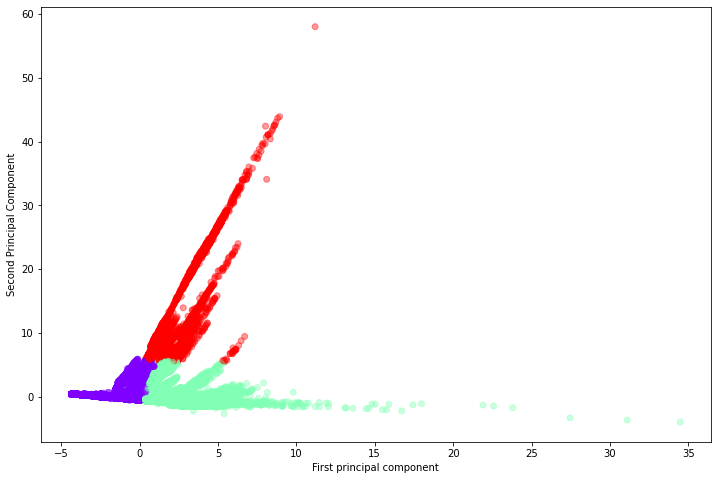

In [78]:
# График распределения кластеров в kmeans
plt.figure(figsize=(12,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=label,cmap='rainbow', alpha=0.4)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [79]:
# Просмотр того, как распределились данные 
label = pd.Series(label)
label.value_counts()

0    147673
1    105883
2      4181
dtype: int64

In [80]:
# Получение распределения от Birch
from sklearn.cluster import Birch

brc = Birch(n_clusters=3)
brc.fit(x_pca)

label2 = brc.predict(x_pca)

Text(0, 0.5, 'Second Principal Component')

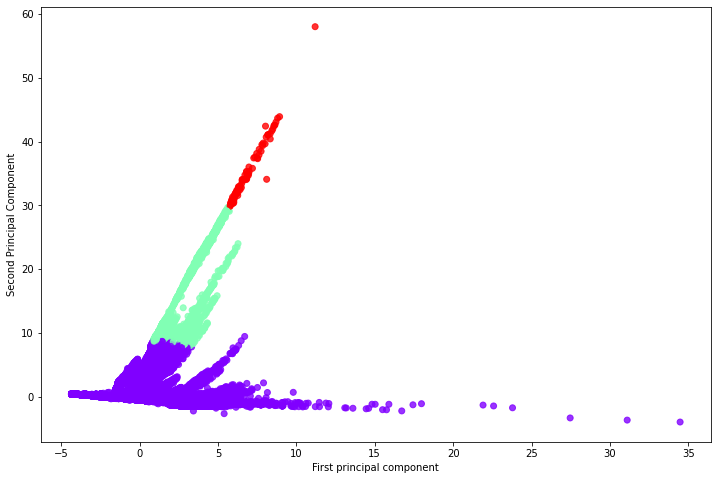

In [81]:
plt.figure(figsize=(12,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=label2,cmap='rainbow', alpha=0.8)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [82]:
# Просмотр того, как распределились данные 
label2 = pd.Series(label2)
label2.value_counts()

0    255733
1      1917
2        87
dtype: int64

In [83]:
# Получение распределения от GaussianMixture
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(3, covariance_type='full', random_state=0).fit(x_pca)

labels3 = gmm.predict(x_pca)

Text(0, 0.5, 'Second Principal Component')

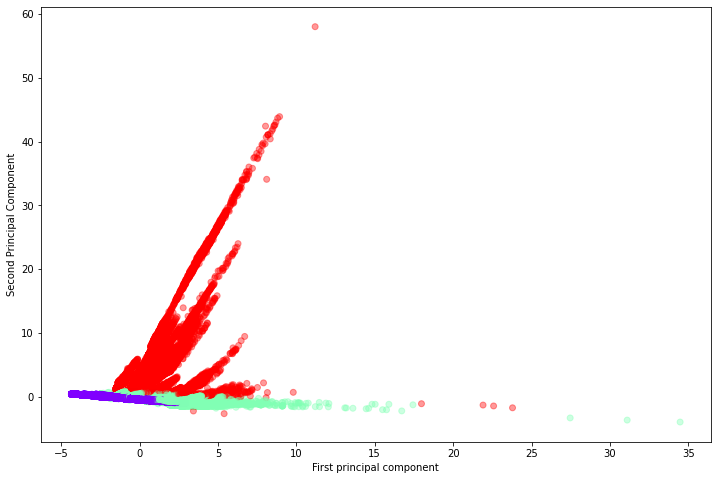

In [84]:
plt.figure(figsize=(12,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=labels3,cmap='rainbow', alpha=0.4)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [85]:
labels3 = pd.Series(labels3)
labels3.value_counts()

0    179551
1     63939
2     14247
dtype: int64

## Метрики качества кластеризации

### [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index)

Метрика применяется в том случае, если известны истинные метки классов. Для вычисления метрики используется функция [adjusted_rand_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) Отчасти метрика напоминает accuracy, так как сравнивает полученные метки классов с известными истинными классами.

Метрика возвращает результат в диапазоне [-1;+1]. Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям. Отрицательные значения говорят о плохом качестве кластеризации.

### [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information)

Для вычисления метрики используется функция [adjusted_mutual_info_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html)

Значение близкое к +1 говорит об очень хорошем качестве кластеризации. Значение близкое к 0 соответствует случайным разбиениям.

### Homogeneity, completeness, V-measure

Для вычисления метрик используется функция [homogeneity_completeness_v_measure.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_completeness_v_measure.html)

- Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
- V-measure - [среднее гармоническое](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B5_%D0%B3%D0%B0%D1%80%D0%BC%D0%BE%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5) от Homogeneity и Completeness.

### Коэффициент силуэта

Для вычисления метрики используется функция [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

Данный метод не требует знания истинных значений меток кластеров.

Пусть:

- $a$ - среднее расстояние между текущей точкой и другими точками этого же кластера.
- $b$ - среднее расстояние между текущей точкой и другими точками следующего ближайшего кластера.

Тогда коэффициент силуэта для точки (объекта) определяется как:

$$ s = \frac{b-a}{max(a,b)} $$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне [-1;1]. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров
(если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

###  Индекс Калински-Харабаша 

Если основные метки истинности неизвестны, sklearn.metrics.calinski_harabasz_scoreдля оценки модели можно использовать индекс Калински-Харабаса ( ), также известный как критерий отношения дисперсии, где более высокий показатель Калински-Харабаса относится к модели с более четко определенными кластерами.

Индекс представляет собой отношение суммы дисперсии между кластерами и внутрикластерной дисперсии для всех кластеров (где дисперсия определяется как сумма квадратов расстояний)

### Индекс Дэвиса-Булдина

Если наземные метки истинности неизвестны, индекс Дэвиса-Булдина ( sklearn.metrics.davies_bouldin_score) можно использовать для оценки модели, где более низкий индекс Дэвиса-Булдина относится к модели с лучшим разделением между кластерами.

Этот индекс означает среднее «сходство» между кластерами, где сходство — это мера, которая сравнивает расстояние между кластерами с размером самих кластеров.

Ноль – это наименьший возможный балл. Значения ближе к нулю указывают на лучший раздел.

In [346]:
# Импорт метрик
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [337]:
print('метрики kmeans = ' + str(metrics.calinski_harabasz_score(x_pca, label)) + '\n' +
     'метрики Birch = ' + str(metrics.calinski_harabasz_score(x_pca, label2)) + '\n' +
      'метрики GaussianMixture = ' + str(metrics.calinski_harabasz_score(x_pca, labels3)))

метрики kmeans = 245851.88461988364
метрики Birch = 42175.312873056544
метрики GaussianMixture = 100730.08194985284
